In [2]:
import KeithleyGUI.keithley as keithley
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pymeasure.instruments.resources import list_resources

%matplotlib inline
try : 
    a = list(list_resources())
except:
    pass
# K = keithley.Keithley6517B()

Matplotlib is building the font cache; this may take a moment.
/Users/colio/workspace/Py_Lang/NUSLab/keithley/NUSLab/.env/lib/python3.12/site-packages/pyvisa_py/tcpip.py:122: UserWarning: TCPIP::hislip resource discovery requires the zeroconf package to be installed... try 'pip install zeroconf'
  warnings.warn(


0 : ASRL/dev/cu.wlan-debug::INSTR : Not known
1 : ASRL/dev/cu.debug-console::INSTR : Not known
2 : ASRL/dev/cu.Bluetooth-Incoming-Port::INSTR : Not known


In [5]:
I = [] 
V = [] 
dir = []

for i in np.linspace(-1, 1, 1000):
    dir.append(np.sign(i))
    I.append(i * 10 ** -3)
    V.append(i * 10 ** 1)

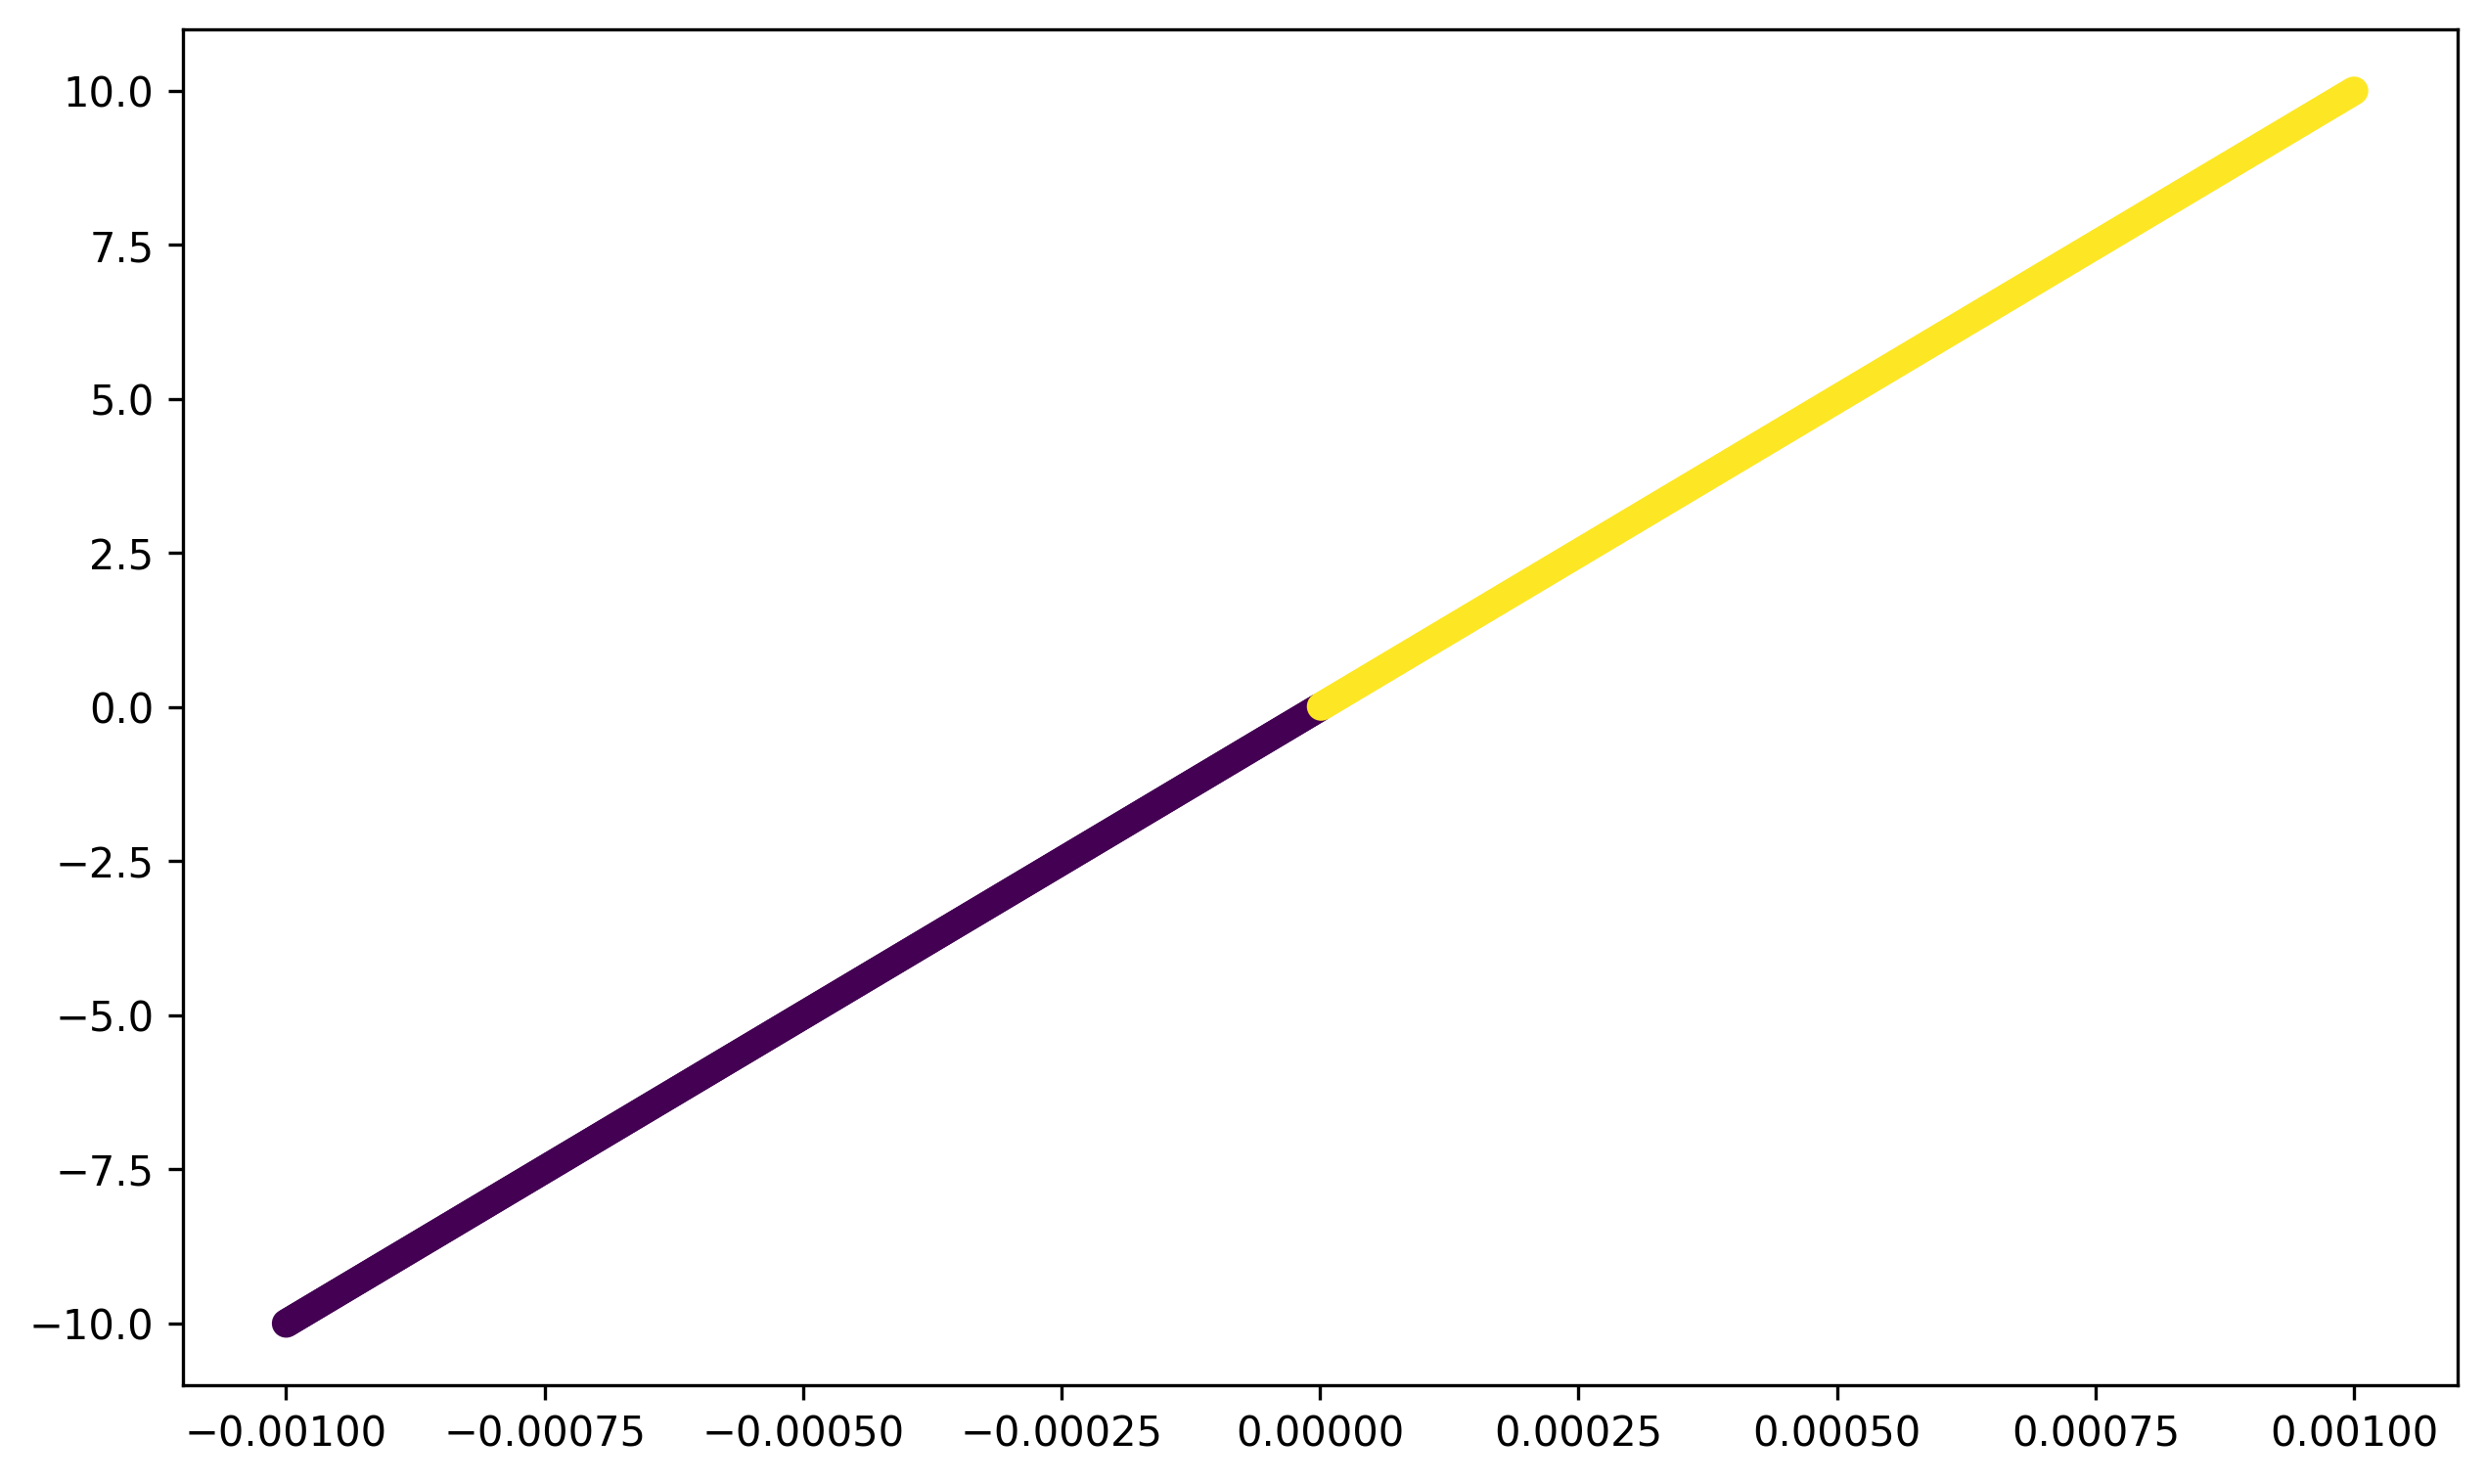

In [12]:
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(I, V, c=dir)

In [81]:
def measure_IV(device, vmin = 0.5 + 0.5e-3, vmax = 0.5 + 1.0e-3, npoints = 10):
    for v_val in np.linspace(vmin, vmax, npoints):
        device.set_voltage(v_val)
        yield (v_val, device.read_current(autorange=False))
    device.set_voltage(0)
    # device.close()

In [74]:
K.set_voltage_range(2)
K.device.write(":SENS:FUNC 'CURR';")
K.device.write(":SENS:CURR:RANG:AUTO OFF;:SENS:CURR:RANG 2e-8")
K.device.write(":SENS:CURR:NPLC 10")

Voltage range set to 2 V


20

In [73]:
K.set_voltage_range(2)

Voltage range set to 2 V


In [1]:
K.set_voltage(0)
K.device.write('OUTP OFF;')

NameError: name 'K' is not defined

In [53]:
K.device.write(':SENS:RES:MAN:VSO:OPER ON;')

28

In [13]:
K.device.write('MEAS:CURR?;')
K.device.read()

'-100.6355E-09NADC,06:45:20.00,09-Oct-2024,+00231RDNG#\n'

In [14]:

K.set_voltage(-1)
K.device.write(':READ?;')
K.device.read()

Voltage set to -1 V and output enabled


'-100.6280E-09NADC,06:45:24.00,09-Oct-2024,+00232RDNG#\n'

In [84]:
I = []
V = []
# keithley.source_voltage = 0
# keithley.enable_source()
# keithley.apply_voltage(voltage_range=5)
# keithley.measure_current(nplc=1, current=0.000105, auto_range=True)

for (v, i) in measure_IV(K, npoints=100):
    I.append(i)
    V.append(v)
    # print(i, v)

Voltage set to 0.5005 V and output enabled
Voltage set to 0.5005050505050505 V and output enabled
Voltage set to 0.500510101010101 V and output enabled
Voltage set to 0.5005151515151515 V and output enabled
Voltage set to 0.500520202020202 V and output enabled
Voltage set to 0.5005252525252525 V and output enabled
Voltage set to 0.500530303030303 V and output enabled
Voltage set to 0.5005353535353535 V and output enabled
Voltage set to 0.500540404040404 V and output enabled
Voltage set to 0.5005454545454545 V and output enabled
Voltage set to 0.500550505050505 V and output enabled
Voltage set to 0.5005555555555555 V and output enabled
Voltage set to 0.500560606060606 V and output enabled
Voltage set to 0.5005656565656565 V and output enabled
Voltage set to 0.500570707070707 V and output enabled
Voltage set to 0.5005757575757576 V and output enabled
Voltage set to 0.5005808080808081 V and output enabled
Voltage set to 0.5005858585858586 V and output enabled
Voltage set to 0.500590909090

In [19]:
I, V

([-3.78e-11,
  1.6824e-09,
  2.6877e-09,
  3.3639e-09,
  4.4153e-09,
  5.4408e-09,
  6.4656e-09,
  7.4951e-09,
  8.5321e-09,
  9.5453e-09,
  1.05625e-08,
  1.15878e-08,
  1.26278e-08,
  1.36337e-08,
  1.46672e-08,
  1.5696e-08,
  1.67143e-08,
  1.77196e-08,
  1.87564e-08,
  1.97677e-08,
  2.04601e-08,
  2.14786e-08,
  2.25018e-08,
  2.35385e-08,
  2.45332e-08,
  2.55718e-08,
  2.66205e-08,
  2.76335e-08,
  2.86568e-08,
  2.9685e-08,
  3.07021e-08,
  3.17564e-08,
  3.27513e-08,
  3.37831e-08,
  3.48186e-08,
  3.585e-08,
  3.6867e-08,
  3.79109e-08,
  3.85967e-08,
  3.96099e-08,
  4.0638e-08,
  4.16471e-08,
  4.26916e-08,
  4.36925e-08,
  4.47111e-08,
  4.57403e-08,
  4.67689e-08,
  4.78025e-08,
  4.88403e-08,
  4.985e-08,
  5.12174e-08,
  5.22579e-08,
  5.32803e-08,
  5.42957e-08,
  5.53136e-08,
  5.63606e-08,
  5.73673e-08,
  5.83954e-08,
  5.94173e-08,
  6.04365e-08,
  6.14492e-08,
  6.24757e-08,
  6.34941e-08,
  6.41786e-08,
  6.52068e-08,
  6.623e-08,
  6.726e-08,
  6.82843e-08,
  6

In [20]:
import csv
# Open file dialog to save CSV
file_name = 'I_V.csv'
if file_name:
    with open(file_name, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Voltage (V)', 'Current (A)'])
        csvwriter.writerows([I, V])

Text(0, 0.5, 'Current (A)')

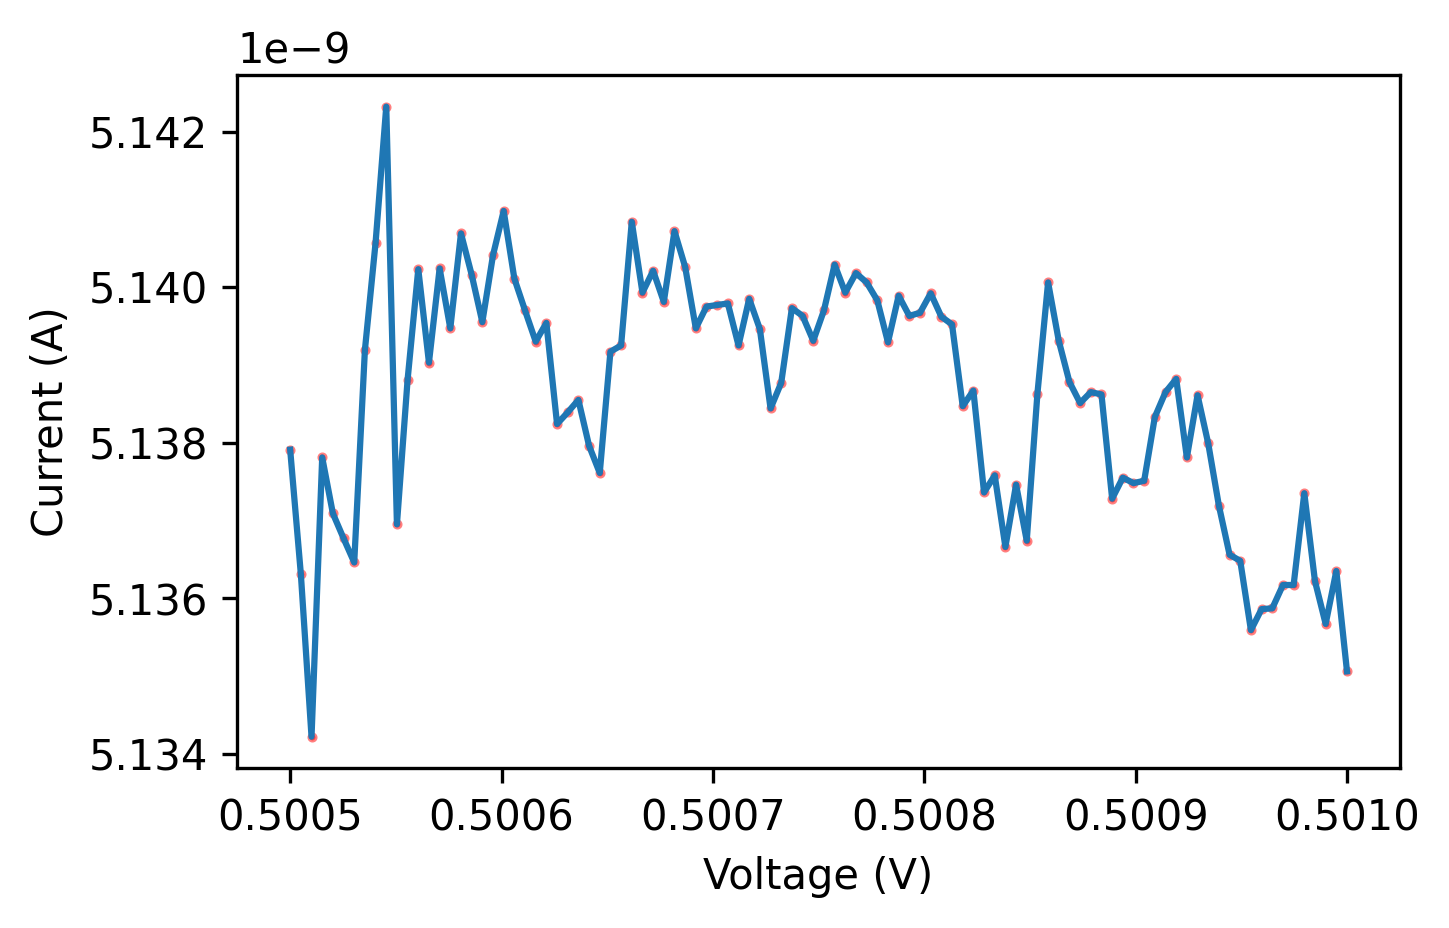

In [85]:
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(V, I)
plt.scatter(V, I, s=2, color='red', alpha=0.5)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
# plt.show()

Text(0, 0.5, 'Resistance (R)')

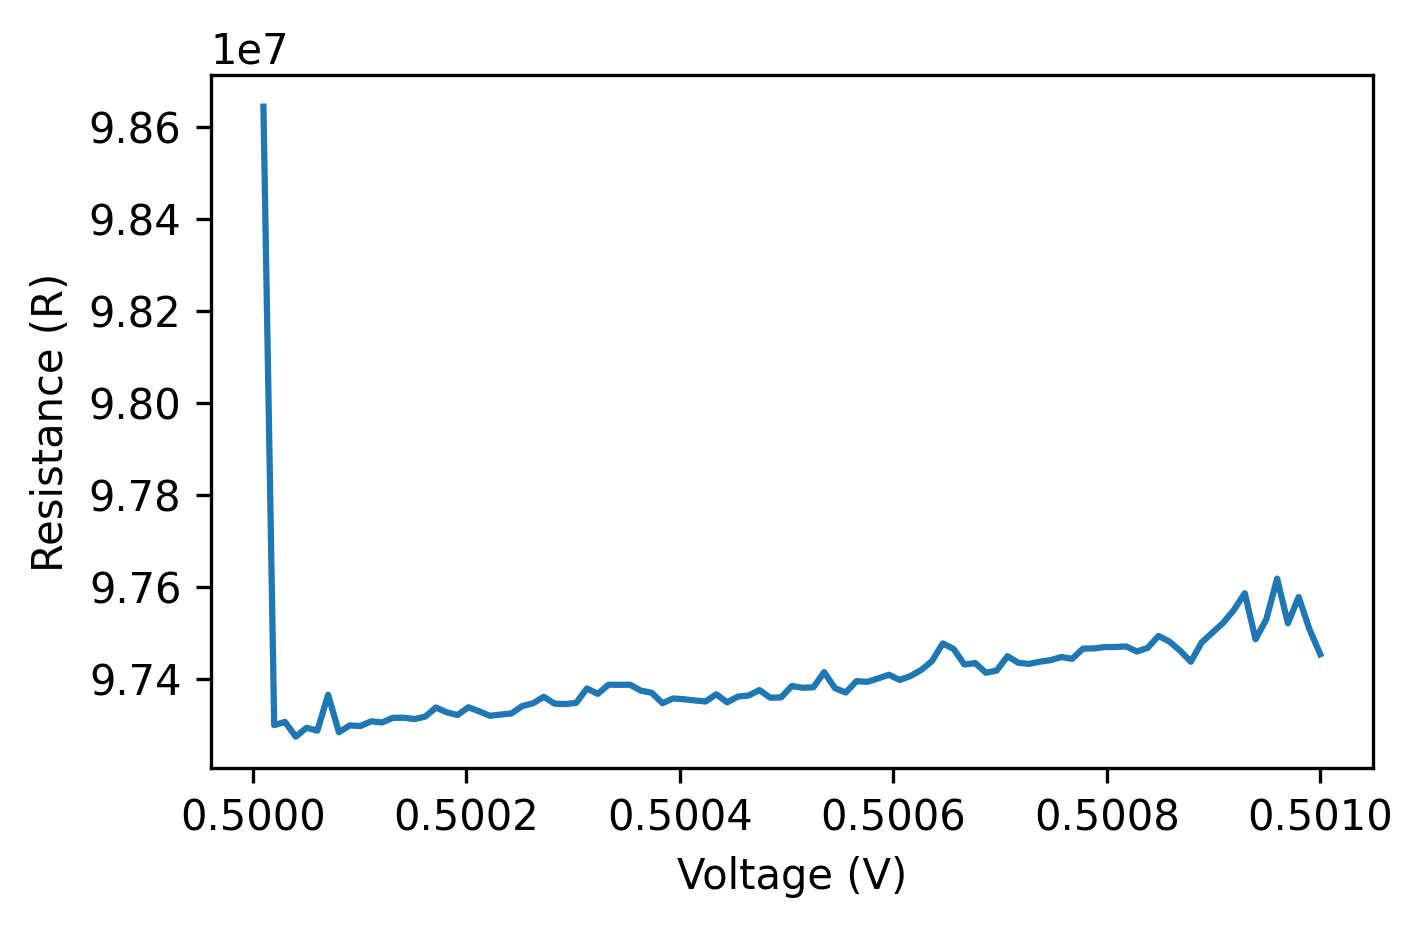

In [80]:
V = np.array(V)
plt.figure(figsize=(5, 3), dpi=300)
# plt.plot(V[10:], (V/I)[10:])
plt.plot(V[1:], (V/I)[1:])
plt.xlabel('Voltage (V)')
plt.ylabel('Resistance (R)')
# plt.show()

In [ ]:
plt.plot(I, V)
plt.show()

In [24]:
K.close()

Connection to Keithley 6517B closed.
